In [2]:
import importlib
import unet

importlib.reload(unet)

from unet import LineSegmenter
from train import LineSegmentationDataset
from pathlib import Path
import sys
sys.path.append("..")

run_name = "20250507_203729_wide_unet_largek_fixed_final"
experiment_folder = Path("./runs") / run_name
model = LineSegmenter.load(experiment_folder)
model = model.to("cuda")

In [3]:
import cv2
import numpy as np
from synthetic import DataGenerator, SynthSettings

gen_settings = SynthSettings(
    downscale_factor=0.5,
    cutout_noise=True,
    cutout_noise_size=200,
    warp_noise=True,
    warp_noise_strength=5
)
generator = DataGenerator(settings=gen_settings)
_, _, scrolls, lines = generator.generate_passages_scrolls(70)

# def resize(imgs: np.ndarray, factor: float):

#     height, width = imgs.shape[1:]
#     nh = int(height * factor)
#     nw = int(width * factor)

#     new_imgs = []
#     for img in imgs:
#         ri = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
#         new_imgs.append(ri)

#     return np.stack(new_imgs)

# scrolls = resize(scrolls, factor=0.5)
# lines = resize(lines, factor=0.5)

In [4]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

def inference(scrolls, lines = None):

    track_loss = lines is not None

    if not track_loss:
        lines = np.empty((scrolls.shape[0], 0))

    data = LineSegmentationDataset(scrolls, lines)
    criterion = nn.BCEWithLogitsLoss()
    hats = []
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_scrolls, batch_lines in DataLoader(data):
            batch_scrolls, batch_lines = batch_scrolls.to("cuda"), batch_lines.to("cuda")
            lines_hat = model(batch_scrolls)
            out = F.sigmoid(lines_hat)
            hats.append(out.cpu().numpy())

            if track_loss:
                loss = criterion(lines_hat, batch_lines)
                test_loss.append(loss.item())


    hats = np.concatenate(hats)
    if track_loss:
        return hats, np.mean(test_loss)
    else:
        hats


hats, loss = inference(scrolls, lines)
loss

np.float64(0.768503914134843)

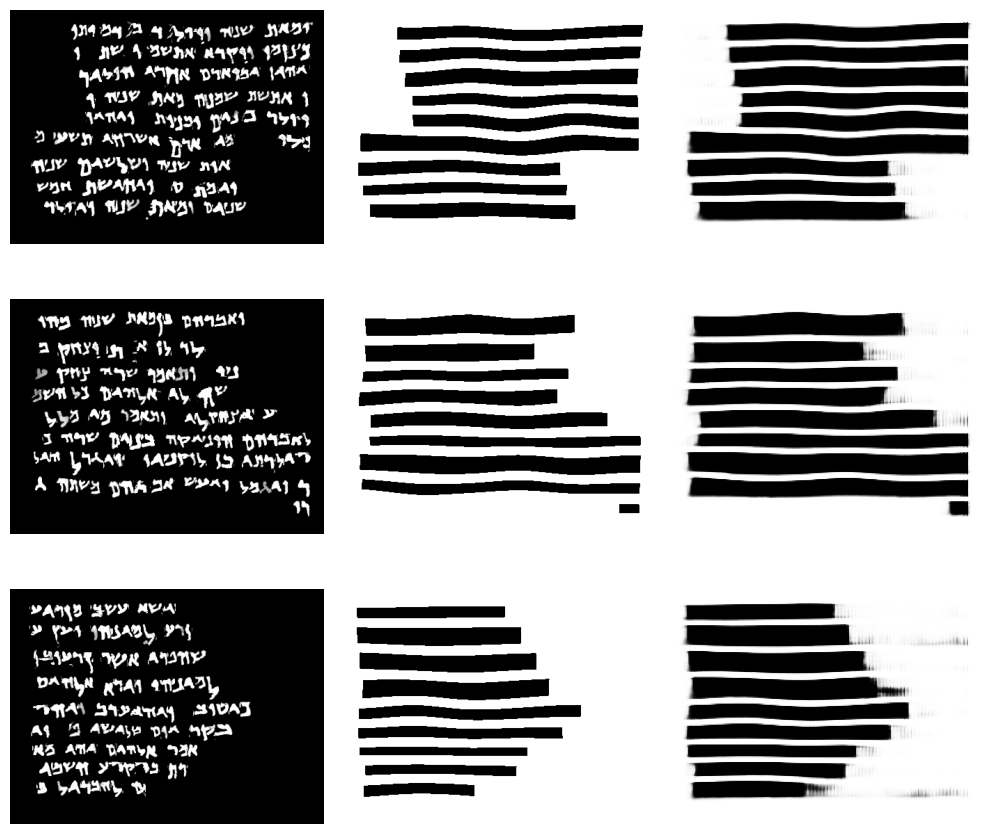

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

inds = np.random.choice(scrolls.shape[0], size=3, replace=False)

for i, index in enumerate(inds):
    ax[i, 0].imshow(scrolls[index], cmap="binary")
    ax[i, 1].imshow(lines[index], cmap="binary")
    ax[i, 2].imshow(np.squeeze(hats[index]), cmap="binary")

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].set_axis_off()

fig.tight_layout()
fig.tight_layout()
plt.show()


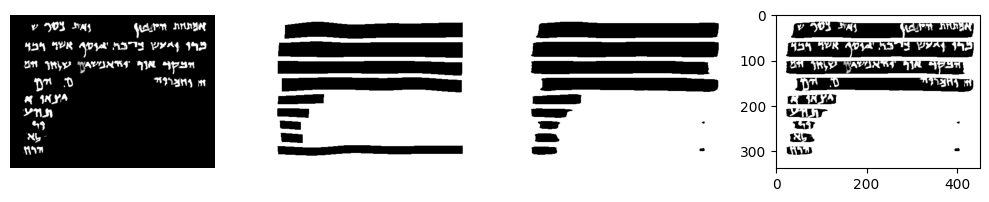

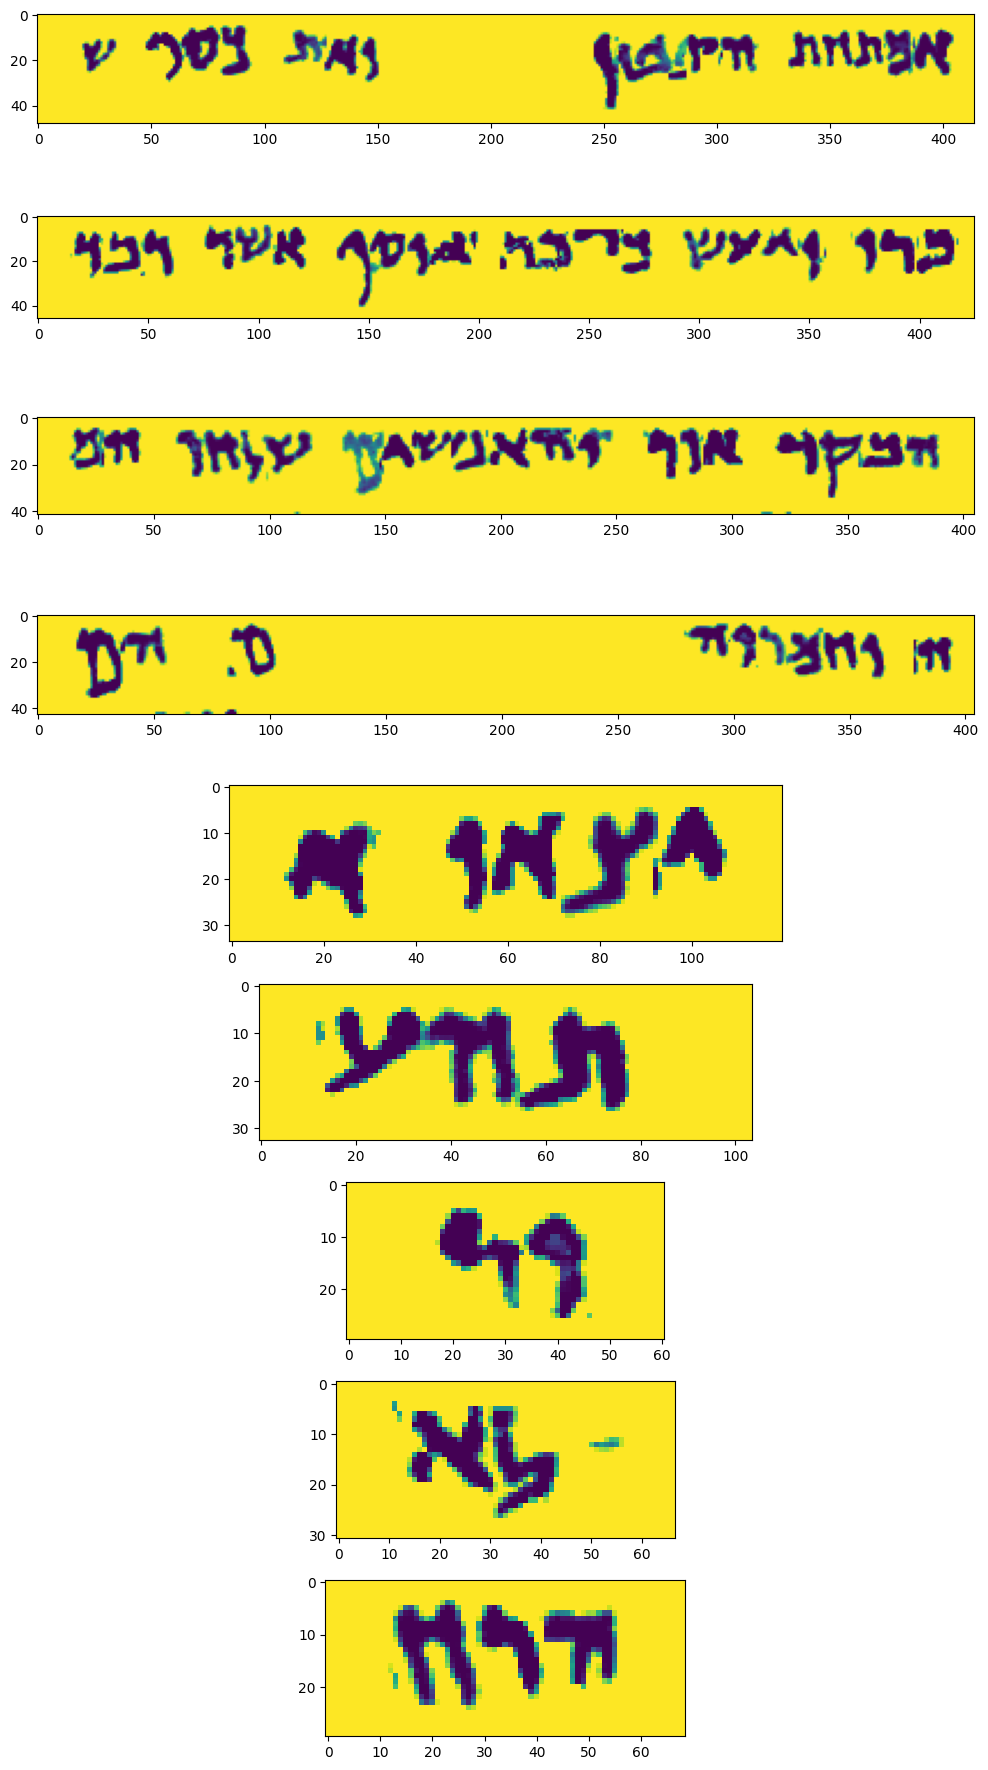

In [214]:
import cv2
import numpy as np

from synthetic import extract_lines_cc

index = 2

hat = np.squeeze(hats[index])
n = 10
kernel = np.ones(n) / n  # simple horizontal blur
hat = convolve1d(hat, kernel, axis=1)
hat = cv2.resize(hat, (scrolls[index].shape[1], scrolls[index].shape[0]), interpolation=cv2.INTER_CUBIC)
hat = (hat > 0.4).astype(float)

ex_lines = extract_lines_cc(scrolls[index], hat)

fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(scrolls[index], cmap="binary")
ax[1].imshow(lines[index], cmap="binary")
ax[2].imshow(hat, cmap="binary")
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
s = np.copy(scrolls[index])
s[~(hat > 0.5)] = 0
ax[3].imshow(s, cmap="binary")

fig.tight_layout()
fig.tight_layout()
plt.show()


fig, axs = plt.subplots(len(ex_lines), 1, figsize=(10, 2 * len(ex_lines)))
for ax, line in zip(axs.ravel(), ex_lines):
    ax.imshow(line)

fig.tight_layout()



In [4]:
from pathlib import Path
from PIL import Image
import cv2

test_data_path = Path(".").resolve().parent / "data" / "image-data"

test_imgs = []

def resize(img: np.ndarray, factor: float):

    height, width = img.shape
    nh = int(height * factor)
    nw = int(width * factor)

    ri = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)

    return ri

for ent in test_data_path.iterdir():

    if ent.is_dir() or not ent.name.endswith("binarized.jpg"):
        continue

    img = Image.open(ent).convert("L")
    img_array = np.array(img)

    text_mask = img_array < 200
    xi, yi = np.where(text_mask)

    xmin, xmax = np.min(xi), np.max(xi)
    ymin, ymax = np.min(yi), np.max(yi)

    img_array = img_array[xmin:xmax, ymin:ymax]

    test_imgs.append(resize(img_array, factor=0.08)[np.newaxis, np.newaxis, :, :])

In [7]:
import torch
import torch.nn.functional as F

test_hats = []
for img in test_imgs:

    img = torch.tensor(img, dtype=torch.float, device="cuda")
    img = 1 - (img / 255)

    with torch.no_grad():
        test_hat = model(img)
        out = F.sigmoid(test_hat)
        test_hats.append(out.squeeze().cpu().numpy())



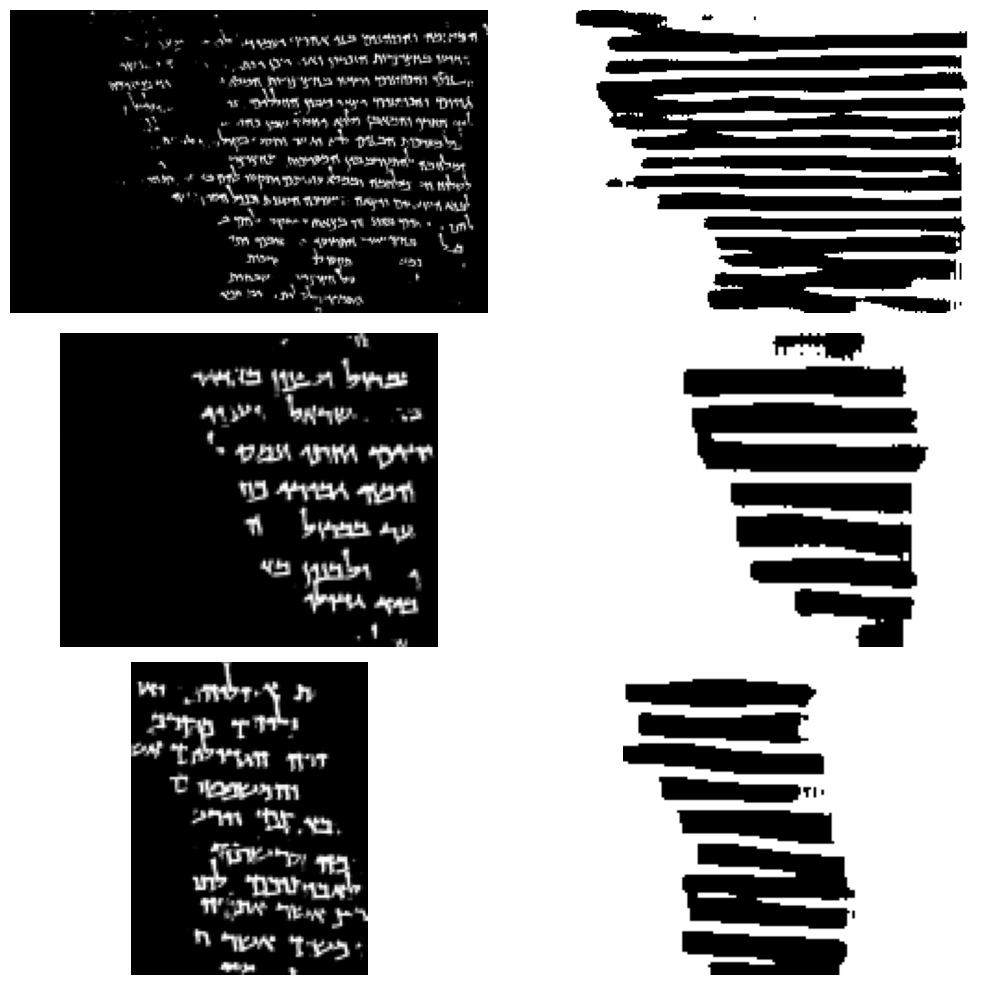

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(10, 10))


inds = np.random.choice(len(test_imgs), size=3, replace=False)

for i, index in enumerate(inds):
    ax[i, 0].imshow(test_imgs[index].squeeze(), cmap="binary")
    ax[i, 1].imshow(test_hats[index].squeeze() > 0.5, cmap="binary")

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()

fig.tight_layout()
fig.tight_layout()
plt.show()


int64


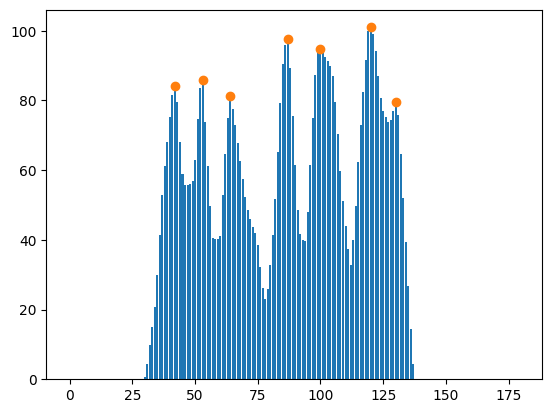

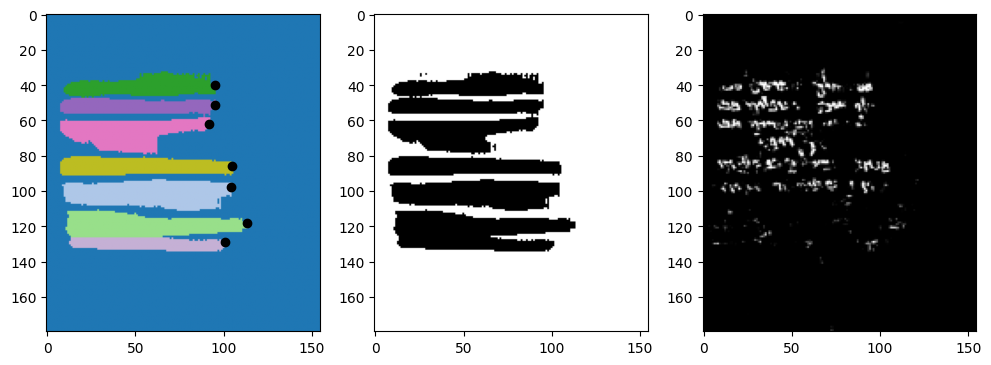

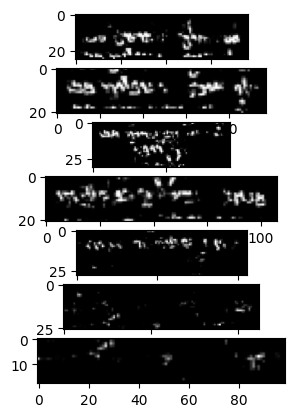

In [ ]:
import heapq
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

colors = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#AEC7E8", "#FFBB78", "#98DF8A", "#FF9896", "#C5B0D5"
]

custom_cmap = ListedColormap(colors)

def find_local_maxima_2nd_derivative(arr):
    arr = np.asarray(arr)
    if arr.ndim != 1:
        raise ValueError("Input must be a 1D array.")

    # First and second discrete derivatives
    first_deriv = np.gradient(arr)
    second_deriv = np.gradient(first_deriv)

    # Candidate maxima: first derivative ~ 0, second derivative negative
    zero_crossings = np.where(np.diff(np.sign(first_deriv)) == -2)[0] + 1
    maxima_indices = [i for i in zero_crossings if second_deriv[i] < 0]

    return np.array(maxima_indices)

def label_hebrew_lines(seg: np.ndarray, min_gap: int = 5):

    H, W   = seg.shape
    labels = np.zeros_like(seg, dtype=np.int32)

    proj = seg.sum(axis=1)
    _n = 7
    proj = np.convolve(proj, np.ones(_n) / _n, mode="same")

    # peaks = find_local_maxima_2nd_derivative(proj)
    peaks, _ = find_peaks(proj)

    fig, ax = plt.subplots()
    vals = proj[peaks]
    ax.bar(np.arange(len(proj)), proj)
    ax.scatter(peaks, vals)


    # Merge close together
    to_merge = set(np.where(np.diff(peaks) < min_gap)[0])
    merged = []
    i = -1
    while i < len(peaks):
        i += 1

        if i >= len(peaks):
            break

        if i in to_merge:
            merged.append(int((peaks[i] + peaks[i + 1]) / 2))
            i += 1
            continue
        else:
            merged.append(peaks[i])


    peaks = np.array(merged)
    print(peaks.dtype)

    # For each peak, scan a small vertical window around it
    # peak_lines = seg[peaks, :]
    # plms = peak_lines > 0.5
    # starts = []
    # for line_id, (p, plm) in enumerate(zip(peaks, plms, strict=True)):
    #     starts.append((p, np.where(plm)[0].max(), line_id))

    starts = []
    for line_id, y0 in enumerate(peaks, start=1):
        y_min = max(0, y0 - 2)
        y_max = min(H, y0 + 2 + 1)
        # right‑most foreground pixel in that window
        cols = np.argmax(seg[y_min:y_max, ::-1], axis=1)
        best_offset = cols.min() # furthest to the right
        if best_offset == 0 and seg[y_min:y_max, -1].all() == 0:
            row = y0
            col = np.flatnonzero(seg[row])[-1]
        else:
            row_idx = np.where(cols == best_offset)[0][0] + y_min
            row = row_idx
            col = W - 1 - best_offset
        starts.append((row, col, line_id))

    pq = []
    for y, x, lid in starts:
        labels[y, x] = lid
        heapq.heappush(pq, (-x, lid, y, x))

    # neighbour order: left first, then up, then down
    neigh = [ ( 0, -1), (-1,  0), ( 1,  0) ]   # (dy, dx)

    while pq:
        negx, lid, y, x = heapq.heappop(pq)

        for dy, dx in neigh:
            ny, nx = y + dy, x + dx
            if (0 <= ny < H) and (0 <= nx < W):
                if seg[ny, nx] and labels[ny, nx] == 0:
                    labels[ny, nx] = lid
                    heapq.heappush(pq, (-nx, lid, ny, nx))

    return labels, peaks, proj, starts

index = np.random.choice(len(test_imgs))

labels, peaks, proj, starts = label_hebrew_lines(test_hats[index].squeeze() > 0.5, min_gap=6)

starts = [v[:-1] for v in starts]
starts = np.array(starts)
Y, X = starts.T

fig, ax = plt.subplots(1, 3, figsize=(12, 10))
ax[0].imshow(labels, cmap=custom_cmap)
ax[0].scatter(X, Y, color="black")

ax[1].imshow(test_hats[index].squeeze() > 0.5, cmap="binary")
ax[2].imshow(test_imgs[index].squeeze(), cmap="binary")


img = np.copy(test_imgs[index].squeeze())

unique_labels = np.unique(labels)

from skimage.morphology import disk, binary_dilation

inflate_px = 5
selem = disk(inflate_px)

line_imgs = []

for group in np.unique(labels):
    if group == 0:
        continue

    gmask = labels == group
    inflated = binary_dilation(gmask, selem)

    ys, xs = np.nonzero(inflated)
    if ys.size == 0:
        continue

    xmin, xmax = ys.min(), ys.max()
    ymin, ymax = xs.min(), xs.max()

    if xmax - xmin <= 4 or ymax - ymin <= 20:
        continue

    sub_img  = img[xmin:xmax + 1, ymin:ymax + 1]
    sub_mask = inflated[xmin:xmax + 1, ymin:ymax + 1]

    line_img = sub_img.copy()
    line_img[~sub_mask] = 255

    line_imgs.append(line_img)

fig, axs = plt.subplots(len(line_imgs))

for ax_i, li in enumerate(line_imgs):
    axs[ax_i].imshow(li, cmap="binary")




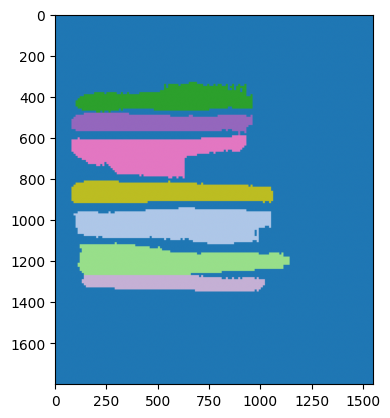

In [15]:

h, w = labels.shape
nh, nw = h * 10, w * 10
plt.imshow(cv2.resize(labels, (nw, nh), interpolation=cv2.INTER_NEAREST), cmap=custom_cmap)

In [ ]:
from pathlib import Path
from PIL import Image

import importlib
import unet

importlib.reload(unet)

from unet import LineSegmenter
from pathlib import Path
import numpy as np


run_name = "20250507_203729_wide_unet_largek_fixed_final"
experiment_folder = Path("./runs") / run_name
model = LineSegmenter.load(experiment_folder)

test_data_path = Path(".").resolve().parent / "data" / "image-data"

test_imgs = []

for ent in test_data_path.iterdir():

    if ent.is_dir() or not ent.name.endswith("binarized.jpg"):
        continue

    img = Image.open(ent).convert("L")
    img_array = np.array(img)
    test_imgs.append(img_array)

out = model.process_heterogenous_images(test_imgs)

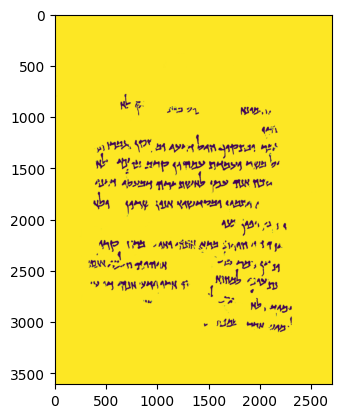

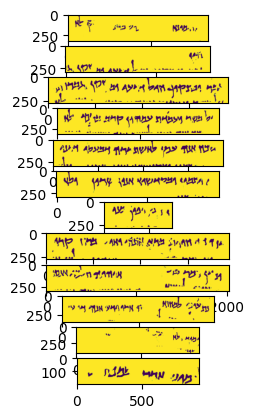

In [6]:
from matplotlib import pyplot as plt

rand_i = np.random.choice(len(out))
lis = out[rand_i]

fig, ax = plt.subplots()

ax.imshow(test_imgs[rand_i])

fig, axs = plt.subplots(len(lis))

for ax, li in zip(axs, lis, strict=True):
    ax.imshow(li)

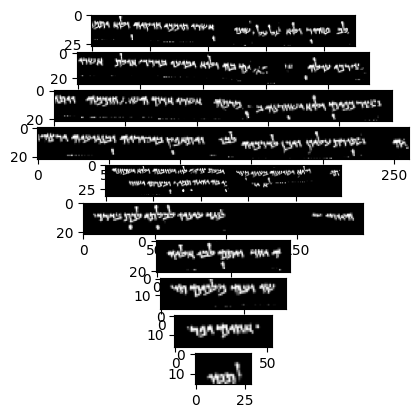

In [ ]:
from skimage.morphology import disk, binary_dilation

inflate_px = 5
selem = disk(inflate_px)

line_imgs = []

for group in np.unique(labels):
    if group == 0:
        continue

    gmask = labels == group
    inflated = binary_dilation(gmask, selem)

    #stop the new pixels from spilling onto another line:
    inflated &= (labels == 0) | gmask


    ys, xs = np.nonzero(inflated)
    if ys.size == 0:
        continue

    xmin, xmax = ys.min(), ys.max()
    ymin, ymax = xs.min(), xs.max()

    if xmax - xmin <= 4 or ymax - ymin <= 20:
        continue

    sub_img  = img[xmin:xmax + 1, ymin:ymax + 1]
    sub_mask = inflated[xmin:xmax + 1, ymin:ymax + 1]

    line_img = sub_img.copy()
    line_img[~sub_mask] = 255

    line_imgs.append(line_img)

fig, axs = plt.subplots(len(line_imgs))

for ax_i, li in enumerate(line_imgs):
    axs[ax_i].imshow(li, cmap="binary")

10 73
11 62
11 77
12 59
12 56
18 66
11 63


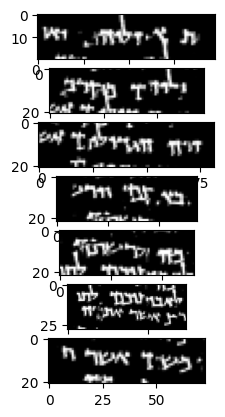

In [ ]:
line_imgs = []
inflate = 5
for group in unique_labels:

    if group == 0:
        continue

    gmask = labels == group
    h, w = gmask.shape

    xi, yi = np.where(gmask)

    xmin, xmax = np.min(xi), np.max(xi)
    ymin, ymax = np.min(yi), np.max(yi)

    width = ymax - ymin

    if width <= 20:
        continue

    height = xmax - xmin

    if height <= 4:
         continue

    xstart = max(0, xmin-inflate)
    ystart = max(0, ymin-inflate)

    xend = min(h, xmax+inflate)
    yend = min(w, ymax+inflate)

    line_imgs.append(img[xstart:xend, ystart:yend])


fig, axs = plt.subplots(len(line_imgs))

for ax_i, li in enumerate(line_imgs):
    axs[ax_i].imshow(li, cmap="binary")


[ 14  25  38  50  63  74  87 100 113 126 138 150]


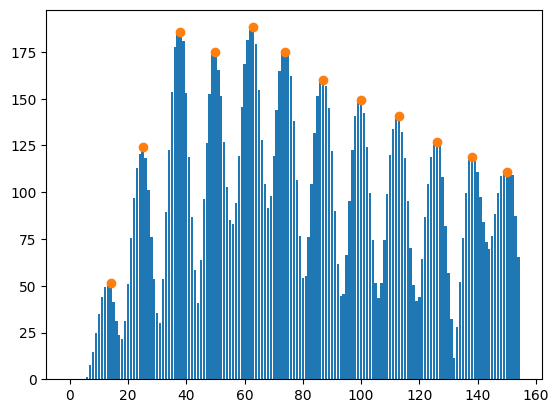

In [ ]:
def find_smooth_local_maxima(arr, window=5):
    if arr.ndim != 1:
        raise ValueError("Input must be a 1D array.")

    n = len(arr)
    maxima_indices = []

    for i in range(window, n - window):
        neighborhood = arr[i - window:i + window + 1]
        if arr[i] == np.max(neighborhood) and np.count_nonzero(neighborhood == arr[i]) == 1:
            maxima_indices.append(i)

    return np.array(maxima_indices)


def find_local_maxima_2nd_derivative(arr):
    arr = np.asarray(arr)
    if arr.ndim != 1:
        raise ValueError("Input must be a 1D array.")

    # First and second discrete derivatives
    first_deriv = np.gradient(arr)
    second_deriv = np.gradient(first_deriv)

    # Candidate maxima: first derivative ~ 0, second derivative negative
    zero_crossings = np.where(np.diff(np.sign(first_deriv)) == -2)[0] + 1
    maxima_indices = [i for i in zero_crossings if second_deriv[i] < 0]

    return np.array(maxima_indices)


proj = (test_hats[1].squeeze() > 0.5).sum(axis=1)

_n = 5
proj = np.convolve(proj, np.ones(_n) / _n, mode="same")
# maximas = find_smooth_local_maxima(proj, window=3)
peaks = find_local_maxima_2nd_derivative(proj)
vals = proj[peaks]

print(peaks)

fig, ax = plt.subplots()
ax.bar(np.arange(len(proj)), proj)
ax.scatter(peaks, vals)

In [ ]:
def find_smooth_local_maxima(arr, window=5):
    if arr.ndim != 1:
        raise ValueError("Input must be a 1D array.")

    n = len(arr)
    maxima_indices = []

    for i in range(window, n - window):
        neighborhood = arr[i - window:i + window + 1]
        if arr[i] == np.max(neighborhood) and np.count_nonzero(neighborhood == arr[i]) == 1:
            maxima_indices.append(i)

    return np.array(maxima_indices)


find_smooth_local_maxima(proj)

array([ 13,  25,  38,  50,  63, 100, 112, 125, 137, 149])

In [153]:
proj

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   7.4,  14.8,
        24.6,  34.8,  44.2,  49.2,  52.8,  51.6,  41.4,  31.2,  23.6,
        21.4,  31. ,  51.2,  75.8,  96.8, 113.2, 120.6, 124.4, 118.4,
       101.2,  76. ,  53.6,  35.6,  30.2,  53.4,  89.6, 122.6, 153.6,
       177.4, 184.4, 185.6, 180.6, 152.8, 118.6,  86.6,  58.4,  40.6,
        63.6,  96.6, 126.4, 152.4, 174.2, 175. , 165.6, 151.6, 126.6,
       102.8,  85.2,  83. ,  94. , 119.4, 145.8, 168.4, 181.6, 186.6,
       188.2, 179.4, 154.8, 128. , 104.4,  91.8,  97.8, 119.6, 144. ,
       165. , 175.2, 175.2, 174.8, 162. , 138. , 106.8,  76.6,  54.2,
        55.4,  76.2, 104.6, 131.8, 151.4, 159.8, 159.8, 156.8, 145.2,
       121.8,  90.2,  61.8,  44.6,  45.6,  66.2,  95.4, 122.4, 140.8,
       149. , 149.4, 142.2, 124.4,  99.8,  74.2,  51.6,  43.4,  51.4,
        74.2,  98.8, 120. , 134. , 141.4, 140.8, 132.2, 118.2,  95.4,
        70.4,  50.6,  41.6,  44. ,  64.2,  86.8, 104.2, 119. , 127.8,
       127. , 125.4,